# Station Outlier filter

This notebook shows the "station outlier filter" to detect... 

The original R code stems from https://github.com/LottedeVos/PWSQC/. 

Publication:
de Vos, L. W., Leijnse, H., Overeem, A., & Uijlenhoet, R. (2019). Quality control for crowdsourced personal weather stations to enable operational rainfall monitoring. _Geophysical Research Letters_, 46(15), 8820-8829.

The idea of the filter is to... 

In [1]:
# Import packages

import warnings

import numpy as np
import xarray as xr
import poligrain as plg
import pandas as pd

In [2]:
# %matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2

In [3]:
# read output data from FZ and HI filters
ds_pws = xr.open_dataset(
    "C:/Users/a002461/OPENSENSE/data/HI_flagged_data_compressed.nc"
)

# slice to time of interest
ds_pws = ds_pws.sel(time=slice("2017-07-01 00:00", "2017-08-01 00:00"))

In [11]:
# this should be an input parameter to the function!

# strict: including only stations that passed the FZ and HI test (fz_flag == 0, hi_flag == 0)
# setting 1 and -1 to NaN
filtered_rain = ds_pws.rainfall.where(
    ds_pws.hi_flag != 0, np.NaN
).to_dataset()  # this should be done for FZ flag as well!

# flex: including stations that passed the FZ and HI filters, and stations that do not have enough neighbours to apply the filters
# setting 1 to -NaN
# filtered_rain = ds_pws.rainfall.where(ds_pws.hi_flag == 1, np.NaN).to_dataset()
filtered_rain

<xarray.Dataset>
Dimensions:    (time: 8929, id: 134)
Coordinates:
  * time       (time) datetime64[ns] 2017-07-01 ... 2017-08-01
  * id         (id) <U6 'ams1' 'ams2' 'ams3' ... 'ams132' 'ams133' 'ams134'
    elevation  (id) <U3 'nan' 'nan' 'nan' 'nan' ... 'nan' 'nan' 'nan' 'nan'
    latitude   (id) float64 52.31 52.3 52.31 52.35 ... 52.31 52.43 52.3 52.26
    longitude  (id) float64 4.671 4.675 4.677 4.678 ... 5.032 5.036 5.041 5.045
    x          (id) float64 2.049e+05 2.052e+05 ... 2.301e+05 2.301e+05
    y          (id) float64 5.804e+06 5.803e+06 ... 5.802e+06 5.798e+06
Data variables:
    rainfall   (id, time) float64 0.101 0.202 0.101 0.202 ... nan nan nan nan

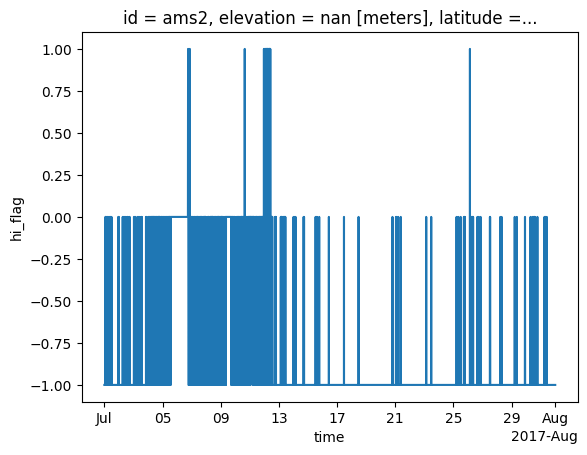

In [12]:
ds_pws.hi_flag.isel(id = 1).plot()

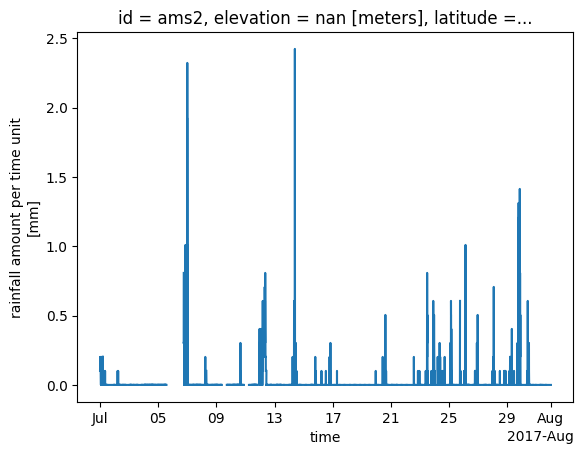

In [13]:
filtered_rain.rainfall.isel(id = 1).plot()

In [14]:
# load distance matrix
distance_matrix = xr.open_dataset("C:/Users/a002461/OPENSENSE/data/distance_matrix.nc")
distance_matrix = distance_matrix.load()

# this renaming should be done before saving the distance matrix...r
distance_matrix = distance_matrix.rename({"__xarray_dataarray_variable__": "distance"})
distance_matrix

<xarray.Dataset>
Dimensions:      (id: 134, id_neighbor: 134)
Coordinates:
  * id           (id) <U6 'ams1' 'ams2' 'ams3' ... 'ams132' 'ams133' 'ams134'
  * id_neighbor  (id_neighbor) <U6 'ams1' 'ams2' 'ams3' ... 'ams133' 'ams134'
Data variables:
    distance     (id, id_neighbor) float64 0.0 518.8 532.0 ... 4.265e+03 0.0

# Apply SO filter

In [15]:
# Set parameters
mint = 4032
mrain = 100
mmatch = 200
gamma = 0.15
beta = 0.2
nstat = 5

In [16]:
# Boolean 2D data array, defining neihbours within max_distance for all stations
max_distance = 10e3
neighbor_matrix = distance_matrix < max_distance

In [17]:
# Default Bias Correction Factor
dbc = 1

In [22]:
# Boolean 2D array (id, time) of true (rain > 0) or false (rain =< 0) for all stations and timesteps
rainy_timesteps = ds_pws.rainfall > 0

In [23]:
rainy_timesteps

<xarray.DataArray 'rainfall' (id: 134, time: 8929)>
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [False,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]])
Coordinates:
  * time       (time) datetime64[ns] 2017-07-01 ... 2017-08-01
  * id         (id) <U6 'ams1' 'ams2' 'ams3' ... 'ams132' 'ams133' 'ams134'
    elevation  (id) <U3 'nan' 'nan' 'nan' 'nan' ... 'nan' 'nan' 'nan' 'nan'
    latitude   (id) float64 52.31 52.3 52.31 52.35 ... 52.31 52.43 52.3 52.26
    longitude  (id) float64 4.671 4.675 4.677 4.678 ... 5.032 5.036 5.041 5.045
    x          (id) float64 2.049e+05 2.052e+05 ... 2.301e+05 2.301e+05
    y          (id) float64 5.804e+06 5.803e+06 ... 5.802e+06 5.798e+06

In [24]:
# cumulative rainy timesteps per station
cum_rainy_timesteps = rainy_timesteps.cumsum(dim="time")

In [25]:
# initialize ugly solution
numbers = np.empty_like(ds_pws.rainfall)
numbers[:, :] = range(len(ds_pws.time))
numbers = numbers.astype(int)
ds_pws["number"] = (("id", "time"), numbers)
ds_pws

<xarray.Dataset>
Dimensions:       (time: 8929, id: 134)
Coordinates:
  * time          (time) datetime64[ns] 2017-07-01 ... 2017-08-01
  * id            (id) <U6 'ams1' 'ams2' 'ams3' ... 'ams132' 'ams133' 'ams134'
    elevation     (id) <U3 'nan' 'nan' 'nan' 'nan' ... 'nan' 'nan' 'nan' 'nan'
    latitude      (id) float64 52.31 52.3 52.31 52.35 ... 52.31 52.43 52.3 52.26
    longitude     (id) float64 4.671 4.675 4.677 4.678 ... 5.036 5.041 5.045
    x             (id) float64 2.049e+05 2.052e+05 ... 2.301e+05 2.301e+05
    y             (id) float64 5.804e+06 5.803e+06 ... 5.802e+06 5.798e+06
Data variables:
    rainfall      (id, time) float64 0.101 0.202 0.101 0.202 ... 0.0 0.0 0.0 0.0
    nbrs_not_nan  (id, time) float32 ...
    reference     (id, time) float64 ...
    hi_flag       (id, time) float32 -1.0 -1.0 -1.0 -1.0 ... 0.0 0.0 0.0 0.0
    number        (id, time) int32 0 1 2 3 4 5 ... 8923 8924 8925 8926 8927 8928
Attributes:
    title:                 PWS data from Amsterdam
    file author:           Maximilian Graf
    institution:           Wageningen University and Research, Department of ...
    date:                  2022-10-18 10:32:00
    source:                Netamo PWS
    history:               Data derived and reformated from the originally pu...
    naming convention:     OpenSense-0.1
    license restrictions:  CC-BY 4.0 https://creativecommons.org/licenses/by/...
    reference:             https://doi.org/10.1029/2019GL083731
    comment:

In [26]:
# initalize with empty numpy array
#so_flag = np.empty_like(ds_pws).astype(int)
so_flag = np.empty_like(ds_pws.rainfall)

In [28]:
%%time

# fix the code so that it is not dependent on "filtered" rainfall

# for i, station_id in enumerate(filtered_rain.id.data):
for i, station_id in enumerate(["ams1"]):  # enumerate(["ams1", "ams45", "ams17"]):
    # one bias correction factor per station, iteratively updated per time step
    BCF_prev = dbc

    # THE NEIGHBOR PICKING SHOULD BE DONE EARLIER IN THE CODE! Already in FZ filter
    # picking stations within range, excluding itself

    nbrs_within_range = (distance_matrix.sel(id=station_id).distance < max_distance) & (
        distance_matrix.sel(id=station_id).distance > 0
    )

    # pick neighbors ids, drop all NanNs
    neighbors = (
        distance_matrix.sel(id=station_id)
        .distance.where(nbrs_within_range, drop=True)
        .id_neighbor
    )

    # if there are not enough stations nearby, or no observations in the time series, all timesteps get flagged as -1
    if (len(neighbors.id_neighbor) < nstat) or (
        ds_pws.rainfall.sel(id=station_id).isnull().all()
    ):
        so_flag[i, :] = -1

    else:
        for j, timestep in enumerate(
            ds_pws.time.isel(time=slice(mint, mint + 5)).data, start=mint
        ):
            # All entries up to mint should be filled with -1

            # fixed evaluation period
            # evaluation_period_start = timestep - mint + 1
            # evaluation_period_end = timestep

            # fixed evaluation period if at least mrain rainy timesteps in the last mint timesteps
            if (
                cum_rainy_timesteps.sel(id=station_id, time=timestep)
                - cum_rainy_timesteps.sel(id=station_id).isel(time=j - mint + 1)
                >= mrain
            ):
                # print('there ARE at least mrain rainy timesteps within the last mint timesteps')
                evaluation_period_start = j - mint  # +1
                evaluation_period_end = j

            # variable evaluation period if less than mrain rainy timesteps in the last mint timesteps (but before the considered period starts)
            elif (cum_rainy_timesteps.sel(id=station_id).isel(time=j).data - mrain) > 0:
                # print('there ARE NOT at least mrain rainy timesteps within the last mint timesteps')

                start_timestamp = (
                    cum_rainy_timesteps.sel(id=station_id)
                    .where(
                        cum_rainy_timesteps.sel(id=station_id).data
                        == (
                            cum_rainy_timesteps.sel(id=station_id).isel(time=j).data
                            - mrain
                        )
                    )
                    .dropna(dim="time")
                    .time.data
                )
                start_timestamp = start_timestamp[-1]

                evaluation_period_start = int(
                    ds_pws.number.sel(id=station_id)
                    .where(
                        ds_pws.number.sel(id=station_id).time.data == start_timestamp
                    )
                    .dropna(dim="time")
                    .data.item()
                )
                evaluation_period_end = j

            else:  # assign -1 to SO filter, we are in the 'warm up period' of the filter
                # print('this wont work sorry')
                so_flag[i, j] = -1

            # number of rainy timesteps within evaulation period from neighbors
            matches = (
                rainy_timesteps.sel(id=neighbors)
                .isel(time=slice(evaluation_period_start, evaluation_period_end))
                .sum()
                .data
            )

            if matches < mmatch:
                so_flag[i, timestep] = -1

            else:
                # suppress runtime warning
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", category=RuntimeWarning)

                    corr_values = np.zeros_like(neighbors, dtype=float)
                    bias_values = np.zeros_like(neighbors, dtype=float)

                    # loop over neighbors
                    for k, neighbor_id in enumerate(neighbors.id_neighbor.data):
                        # pearson correlation with neighboring stations
                        corr = xr.corr(
                            ds_pws.rainfall.sel(id=station_id).isel(
                                time=slice(
                                    evaluation_period_start, evaluation_period_end
                                )
                            ),
                            ds_pws.rainfall.sel(id=neighbor_id).isel(
                                time=slice(
                                    evaluation_period_start, evaluation_period_end
                                )
                            ),
                        )
                        corr_values[k] = corr.data  # ???

                        # rain_pws - rain_reference (can be for example neighboring stations or radar)
                        delta_r = ds_pws.rainfall.sel(id=station_id).isel(
                            time=slice(evaluation_period_start, evaluation_period_end)
                        ) - ds_pws.rainfall.sel(id=neighbor_id).isel(
                            time=slice(evaluation_period_start, evaluation_period_end)
                        )

                        bias = np.nanmean(delta_r) / np.nanmean(
                            ds_pws.rainfall.sel(id=neighbor_id).isel(
                                time=slice(
                                    evaluation_period_start, evaluation_period_end
                                )
                            )
                        )
                        bias_values[k] = bias

                        # If the median of the r values falls short of threshold gamma, the SO flag is set to 1.
                        median_correlation = np.median(corr_values)

                        if median_correlation > gamma:
                            bias_values[np.isinf(bias_values)] = np.nan
                            median_bias = np.nanmedian(
                                bias_values
                            )  # median of bias of indivial bias to all neigbors
                            BCFnew = 1 / (1 + median_bias)
                            if np.abs(np.log(BCFnew / BCF_prev)) > np.log(1 + beta):
                                BCF_prev = BCFnew

                        # if pearson correlation is too low, then it is a "station outlier"
                        else:
                            so_flag[i, j] = 1


CPU times: total: 4.03 s
Wall time: 4.03 s


In [29]:
# add flags to dataset
ds_pws["so_flag"] = (("id", "time"), so_flag)